In [1]:
import os,time,math,signal,random,shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import input_data
from decimal import Decimal

In [2]:
def format_e(n):
    a = '%E' % n
    return a.split('E')[0].rstrip('0').rstrip('.') + 'E' + a.split('E')[1]

In [3]:
class FitNN:
    def __init__(self, train_inputs, train_stouts, layers):
        self.layers = layers
        self.num_layers = len(self.layers)
        # Training Data
        self.inputs = train_inputs
        self.stouts = train_stouts
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(self.layers)
        # tf placeholders and graph
        self.sess = tf.Session()
        self.saver = tf.train.Saver() # To Save Trainning Process
        self.MODEL_SAVE_PATH = './model/'
        self.MODEL_NAME='fitNN_model'
        self.LOG_NAME = './log'
        self.merged = tf.summary.merge_all()
        self.writer = tf.summary.FileWriter(self.LOG_NAME, self.sess.graph)
        self.input_tf = tf.placeholder(tf.float32, shape=[None, self.layers[0]])
        self.stout_tf =  tf.placeholder(tf.float32, shape=[None, self.layers[-1]])
        self.out_pred = self.neural_net(self.input_tf, self.weights, self.biases) 

        self.loss = tf.reduce_mean(tf.square(self.log10(self.stout_tf) - self.out_pred))
        self.optimizer = tf.train.AdamOptimizer(0.00001)
        self.train_op = self.optimizer.minimize(self.loss)
        self.batch_size = 100

        self.wb_rec_path = './wb_rec/'
        if os.path.exists(self.wb_rec_path) != True:
            os.makedirs(self.wb_rec_path)
        
        init = tf.global_variables_initializer()
        self.sess.run(init)   


    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for i in range(0,num_layers-1):
            W = tf.Variable(tf.random_normal([layers[i],layers[i+1]]))
            b = tf.Variable(tf.zeros([1,layers[i+1]]) + 0.1)
            weights.append(W)
            biases.append(b)
        return weights,biases

    def log10(self, x):
        numerator = tf.log(x)
        denominator = tf.log(tf.constant(10, dtype=numerator.dtype))
        return numerator / denominator

    def neural_net(self, inputs, weights, biases):
        num_layers = len(weights) + 1 
        h = self.log10(inputs)
        for l in range(num_layers - 2):
            W = weights[l]
            b = biases[l]
            h = tf.nn.sigmoid(tf.add(tf.matmul(h,W),b))
        W = weights[-1]
        b = biases[-1]
        h = tf.add(tf.matmul(h,W),b)
        return h
    
    def train(self,nIter):
        tf_train_dict = {
                        self.input_tf: self.inputs, self.stout_tf: self.stouts
                        }
        
        # Restore Last Training Model 
        ckpt = tf.train.get_checkpoint_state(self.MODEL_SAVE_PATH)
        if ckpt and ckpt.model_checkpoint_path:
           self.saver.restore(self.sess, ckpt.model_checkpoint_path)
           print("Model Restored.")
        
        mini_batches_i = [self.inputs[k:k+self.batch_size] for k in range(0,len(self.inputs), self.batch_size)]
        mini_batches_sto = [self.stouts[k:k+self.batch_size] for k in range(0,len(self.stouts), self.batch_size)]
        start_time = time.time()
        begin_time = start_time
        for it in range(nIter):
            # Use every batch to update weights and biases
            self.sess.run(self.train_op, tf_train_dict)
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_train_dict)
                print('It: %d, Loss: %.5e, Time: %.2f' %(it, loss_value, elapsed))
                start_time = time.time()
            # Save weights and biases every 1000 epoch
            if it % 1000 == 0:
                rec_folder_name = str(it) +'wbRec/'
                if os.path.exists(self.wb_rec_path+rec_folder_name) != True:
                    os.makedirs(self.wb_rec_path+rec_folder_name)  
                for j in range(self.num_layers-1):
                    temp_w_rec = self.weights[j].eval(session=self.sess)
                    temp_b_rec = self.biases[j].eval(session=self.sess)
                    np.save(self.wb_rec_path+rec_folder_name+'w_rec'+str(j+1)+'.npy', temp_w_rec) 
                    np.save(self.wb_rec_path+rec_folder_name+'b_rec'+str(j+1)+'.npy', temp_b_rec)   
                np.save('loss.npy',loss_value)
                text_file = open("loss.txt", "a")
                loss_for_save =str(it) + ' ' + format_e(loss_value) + ' ' + str(time.time() - begin_time) + '\n' 
                text_file.write(loss_for_save)
                text_file.close()   
                # Save model 
                self.saver.save(self.sess, os.path.join(self.MODEL_SAVE_PATH, self.MODEL_NAME))
         

In [4]:
os.system('mv loss.txt loss_last.txt')
wraper = input_data.DataWrapper()
h_layers = 5
h_nodes = 20
folder = './wb_rec/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

layers = [2] + [h_nodes]*h_layers + [1]
text_file = open("nn_structure.txt", "w")
layers_for_save = 'hlayers:' + str(h_layers) + ' hnodes:' + str(h_nodes)
text_file.write(layers_for_save)
text_file.close()
np.save('./wb_rec/layers.npy',layers)

In [5]:
train_i,train_l = wraper.read_data_sets(wraper.all_data)
model = FitNN(train_i,train_l,layers)
model.train(600000)

INFO:tensorflow:Restoring parameters from ./model/fitNN_model
Model Restored.
It: 0, Loss: 1.12026e-06, Time: 0.43
It: 100, Loss: 1.11494e-06, Time: 0.27
It: 200, Loss: 1.11492e-06, Time: 0.14
It: 300, Loss: 1.11487e-06, Time: 0.15
It: 400, Loss: 1.11481e-06, Time: 0.16
It: 500, Loss: 1.11473e-06, Time: 0.14
It: 600, Loss: 1.11464e-06, Time: 0.15
It: 700, Loss: 1.11454e-06, Time: 0.16
It: 800, Loss: 1.11445e-06, Time: 0.14
It: 900, Loss: 1.11433e-06, Time: 0.17
It: 1000, Loss: 1.11420e-06, Time: 0.15
It: 1100, Loss: 1.11407e-06, Time: 0.19
It: 1200, Loss: 1.11392e-06, Time: 0.16
It: 1300, Loss: 1.11375e-06, Time: 0.14
It: 1400, Loss: 1.11357e-06, Time: 0.15
It: 1500, Loss: 1.11339e-06, Time: 0.16
It: 1600, Loss: 1.11319e-06, Time: 0.14
It: 1700, Loss: 1.11297e-06, Time: 0.16
It: 1800, Loss: 1.11381e-06, Time: 0.15
It: 1900, Loss: 1.11273e-06, Time: 0.14
It: 2000, Loss: 1.11265e-06, Time: 0.16
It: 2100, Loss: 1.11259e-06, Time: 0.20
It: 2200, Loss: 1.11247e-06, Time: 0.14
It: 2300, Loss

It: 20100, Loss: 1.08835e-06, Time: 0.19
It: 20200, Loss: 1.08820e-06, Time: 0.14
It: 20300, Loss: 1.08800e-06, Time: 0.15
It: 20400, Loss: 1.08779e-06, Time: 0.14
It: 20500, Loss: 1.22328e-06, Time: 0.14
It: 20600, Loss: 1.08752e-06, Time: 0.15
It: 20700, Loss: 1.08743e-06, Time: 0.14
It: 20800, Loss: 1.08736e-06, Time: 0.14
It: 20900, Loss: 1.08729e-06, Time: 0.15
It: 21000, Loss: 1.08719e-06, Time: 0.14
It: 21100, Loss: 1.08710e-06, Time: 0.19
It: 21200, Loss: 1.08700e-06, Time: 0.15
It: 21300, Loss: 1.08690e-06, Time: 0.14
It: 21400, Loss: 1.08680e-06, Time: 0.16
It: 21500, Loss: 1.08671e-06, Time: 0.14
It: 21600, Loss: 1.08655e-06, Time: 0.15
It: 21700, Loss: 1.08643e-06, Time: 0.16
It: 21800, Loss: 1.08630e-06, Time: 0.14
It: 21900, Loss: 1.08615e-06, Time: 0.16
It: 22000, Loss: 1.08602e-06, Time: 0.15
It: 22100, Loss: 1.08586e-06, Time: 0.18
It: 22200, Loss: 1.08568e-06, Time: 0.16
It: 22300, Loss: 1.08552e-06, Time: 0.14
It: 22400, Loss: 1.08532e-06, Time: 0.14
It: 22500, Loss:

It: 40100, Loss: 1.06277e-06, Time: 0.17
It: 40200, Loss: 1.06267e-06, Time: 0.16
It: 40300, Loss: 1.06260e-06, Time: 0.15
It: 40400, Loss: 1.06252e-06, Time: 0.14
It: 40500, Loss: 1.06242e-06, Time: 0.17
It: 40600, Loss: 1.06233e-06, Time: 0.14
It: 40700, Loss: 1.06225e-06, Time: 0.15
It: 40800, Loss: 1.06210e-06, Time: 0.16
It: 40900, Loss: 1.06201e-06, Time: 0.14
It: 41000, Loss: 1.06188e-06, Time: 0.15
It: 41100, Loss: 1.06177e-06, Time: 0.19
It: 41200, Loss: 1.06163e-06, Time: 0.14
It: 41300, Loss: 1.06150e-06, Time: 0.18
It: 41400, Loss: 1.06131e-06, Time: 0.14
It: 41500, Loss: 1.06118e-06, Time: 0.15
It: 41600, Loss: 1.06102e-06, Time: 0.16
It: 41700, Loss: 1.06081e-06, Time: 0.14
It: 41800, Loss: 1.06063e-06, Time: 0.15
It: 41900, Loss: 1.06044e-06, Time: 0.16
It: 42000, Loss: 1.06026e-06, Time: 0.14
It: 42100, Loss: 1.06019e-06, Time: 0.19
It: 42200, Loss: 1.06009e-06, Time: 0.14
It: 42300, Loss: 1.06003e-06, Time: 0.15
It: 42400, Loss: 1.05996e-06, Time: 0.17
It: 42500, Loss:

It: 60100, Loss: 1.03873e-06, Time: 0.20
It: 60200, Loss: 1.03867e-06, Time: 0.18
It: 60300, Loss: 1.03861e-06, Time: 0.15
It: 60400, Loss: 1.03852e-06, Time: 0.16
It: 60500, Loss: 1.03840e-06, Time: 0.16
It: 60600, Loss: 1.03832e-06, Time: 0.14
It: 60700, Loss: 1.03824e-06, Time: 0.16
It: 60800, Loss: 1.03812e-06, Time: 0.14
It: 60900, Loss: 1.03802e-06, Time: 0.15
It: 61000, Loss: 1.03789e-06, Time: 0.16
It: 61100, Loss: 1.03778e-06, Time: 0.17
It: 61200, Loss: 1.03764e-06, Time: 0.15
It: 61300, Loss: 1.03749e-06, Time: 0.16
It: 61400, Loss: 1.03734e-06, Time: 0.15
It: 61500, Loss: 1.03722e-06, Time: 0.16
It: 61600, Loss: 1.03703e-06, Time: 0.14
It: 61700, Loss: 1.03688e-06, Time: 0.15
It: 61800, Loss: 1.03670e-06, Time: 0.16
It: 61900, Loss: 1.03651e-06, Time: 0.14
It: 62000, Loss: 1.04937e-06, Time: 0.14
It: 62100, Loss: 1.03630e-06, Time: 0.18
It: 62200, Loss: 1.03622e-06, Time: 0.14
It: 62300, Loss: 1.03615e-06, Time: 0.16
It: 62400, Loss: 1.03607e-06, Time: 0.14
It: 62500, Loss:

It: 80100, Loss: 1.01597e-06, Time: 0.19
It: 80200, Loss: 1.01580e-06, Time: 0.14
It: 80300, Loss: 1.01563e-06, Time: 0.16
It: 80400, Loss: 1.02222e-06, Time: 0.15
It: 80500, Loss: 1.01541e-06, Time: 0.15
It: 80600, Loss: 1.01536e-06, Time: 0.16
It: 80700, Loss: 1.01530e-06, Time: 0.15
It: 80800, Loss: 1.01520e-06, Time: 0.15
It: 80900, Loss: 1.01515e-06, Time: 0.17
It: 81000, Loss: 1.01508e-06, Time: 0.13
It: 81100, Loss: 1.01499e-06, Time: 0.19
It: 81200, Loss: 1.01492e-06, Time: 0.15
It: 81300, Loss: 1.01482e-06, Time: 0.15
It: 81400, Loss: 1.01475e-06, Time: 0.16
It: 81500, Loss: 1.01464e-06, Time: 0.15
It: 81600, Loss: 1.01456e-06, Time: 0.15
It: 81700, Loss: 1.01442e-06, Time: 0.16
It: 81800, Loss: 1.01432e-06, Time: 0.13
It: 81900, Loss: 1.01420e-06, Time: 0.16
It: 82000, Loss: 1.01408e-06, Time: 0.16
It: 82100, Loss: 1.01395e-06, Time: 0.18
It: 82200, Loss: 1.01381e-06, Time: 0.16
It: 82300, Loss: 1.01368e-06, Time: 0.14
It: 82400, Loss: 1.01351e-06, Time: 0.15
It: 82500, Loss:

It: 100100, Loss: 9.94458e-07, Time: 0.19
It: 100200, Loss: 9.94363e-07, Time: 0.15
It: 100300, Loss: 9.94311e-07, Time: 0.14
It: 100400, Loss: 9.94219e-07, Time: 0.16
It: 100500, Loss: 9.94141e-07, Time: 0.15
It: 100600, Loss: 9.94036e-07, Time: 0.14
It: 100700, Loss: 9.93950e-07, Time: 0.16
It: 100800, Loss: 9.93851e-07, Time: 0.13
It: 100900, Loss: 9.93735e-07, Time: 0.15
It: 101000, Loss: 9.93623e-07, Time: 0.15
It: 101100, Loss: 9.93497e-07, Time: 0.18
It: 101200, Loss: 9.93347e-07, Time: 0.16
It: 101300, Loss: 9.93237e-07, Time: 0.14
It: 101400, Loss: 9.93088e-07, Time: 0.14
It: 101500, Loss: 9.92911e-07, Time: 0.16
It: 101600, Loss: 9.92760e-07, Time: 0.14
It: 101700, Loss: 9.92587e-07, Time: 0.15
It: 101800, Loss: 9.92423e-07, Time: 0.14
It: 101900, Loss: 9.92380e-07, Time: 0.14
It: 102000, Loss: 9.92284e-07, Time: 0.16
It: 102100, Loss: 9.92213e-07, Time: 0.17
It: 102200, Loss: 9.92168e-07, Time: 0.14
It: 102300, Loss: 9.92103e-07, Time: 0.16
It: 102400, Loss: 9.92056e-07, Tim

It: 119700, Loss: 9.74335e-07, Time: 0.16
It: 119800, Loss: 9.74288e-07, Time: 0.13
It: 119900, Loss: 9.74229e-07, Time: 0.16
It: 120000, Loss: 9.74152e-07, Time: 0.15
It: 120100, Loss: 9.74077e-07, Time: 0.17
It: 120200, Loss: 9.73996e-07, Time: 0.16
It: 120300, Loss: 9.73922e-07, Time: 0.14
It: 120400, Loss: 9.73836e-07, Time: 0.15
It: 120500, Loss: 9.73742e-07, Time: 0.16
It: 120600, Loss: 9.73644e-07, Time: 0.14
It: 120700, Loss: 9.73548e-07, Time: 0.16
It: 120800, Loss: 9.73442e-07, Time: 0.15
It: 120900, Loss: 9.73319e-07, Time: 0.14
It: 121000, Loss: 9.73196e-07, Time: 0.16
It: 121100, Loss: 9.73065e-07, Time: 0.17
It: 121200, Loss: 9.72938e-07, Time: 0.14
It: 121300, Loss: 9.72797e-07, Time: 0.16
It: 121400, Loss: 9.72656e-07, Time: 0.13
It: 121500, Loss: 9.72487e-07, Time: 0.15
It: 121600, Loss: 9.72333e-07, Time: 0.15
It: 121700, Loss: 1.69497e-06, Time: 0.14
It: 121800, Loss: 9.72097e-07, Time: 0.16
It: 121900, Loss: 9.72047e-07, Time: 0.15
It: 122000, Loss: 9.71977e-07, Tim

It: 139300, Loss: 9.55135e-07, Time: 0.15
It: 139400, Loss: 9.55081e-07, Time: 0.14
It: 139500, Loss: 9.55011e-07, Time: 0.17
It: 139600, Loss: 9.54954e-07, Time: 0.13
It: 139700, Loss: 9.54886e-07, Time: 0.16
It: 139800, Loss: 9.54831e-07, Time: 0.15
It: 139900, Loss: 9.54746e-07, Time: 0.15
It: 140000, Loss: 9.54677e-07, Time: 0.16
It: 140100, Loss: 9.54617e-07, Time: 0.19
It: 140200, Loss: 9.54509e-07, Time: 0.17
It: 140300, Loss: 9.54413e-07, Time: 0.16
It: 140400, Loss: 9.54331e-07, Time: 0.14
It: 140500, Loss: 9.54244e-07, Time: 0.17
It: 140600, Loss: 9.54130e-07, Time: 0.14
It: 140700, Loss: 9.54030e-07, Time: 0.15
It: 140800, Loss: 9.53913e-07, Time: 0.16
It: 140900, Loss: 9.53778e-07, Time: 0.14
It: 141000, Loss: 9.53654e-07, Time: 0.15
It: 141100, Loss: 9.53507e-07, Time: 0.19
It: 141200, Loss: 9.53362e-07, Time: 0.14
It: 141300, Loss: 9.53227e-07, Time: 0.17
It: 141400, Loss: 9.53069e-07, Time: 0.14
It: 141500, Loss: 9.55024e-07, Time: 0.16
It: 141600, Loss: 9.52897e-07, Tim

It: 158900, Loss: 9.36894e-07, Time: 0.15
It: 159000, Loss: 9.36821e-07, Time: 0.16
It: 159100, Loss: 9.36778e-07, Time: 0.17
It: 159200, Loss: 9.36704e-07, Time: 0.14
It: 159300, Loss: 9.36648e-07, Time: 0.14
It: 159400, Loss: 9.36578e-07, Time: 0.16
It: 159500, Loss: 9.36508e-07, Time: 0.16
It: 159600, Loss: 9.36427e-07, Time: 0.14
It: 159700, Loss: 9.36341e-07, Time: 0.16
It: 159800, Loss: 9.36239e-07, Time: 0.14
It: 159900, Loss: 9.36156e-07, Time: 0.15
It: 160000, Loss: 9.36080e-07, Time: 0.16
It: 160100, Loss: 9.35976e-07, Time: 0.18
It: 160200, Loss: 9.35883e-07, Time: 0.15
It: 160300, Loss: 9.35762e-07, Time: 0.15
It: 160400, Loss: 9.35655e-07, Time: 0.14
It: 160500, Loss: 9.35523e-07, Time: 0.17
It: 160600, Loss: 9.35386e-07, Time: 0.14
It: 160700, Loss: 9.35241e-07, Time: 0.15
It: 160800, Loss: 9.35111e-07, Time: 0.16
It: 160900, Loss: 9.34950e-07, Time: 0.14
It: 161000, Loss: 1.83706e-06, Time: 0.15
It: 161100, Loss: 9.34764e-07, Time: 0.18
It: 161200, Loss: 9.34691e-07, Tim

It: 178500, Loss: 9.19378e-07, Time: 0.17
It: 178600, Loss: 9.19326e-07, Time: 0.14
It: 178700, Loss: 9.19273e-07, Time: 0.15
It: 178800, Loss: 9.19215e-07, Time: 0.16
It: 178900, Loss: 9.19171e-07, Time: 0.14
It: 179000, Loss: 9.19090e-07, Time: 0.15
It: 179100, Loss: 9.19040e-07, Time: 0.18
It: 179200, Loss: 9.18993e-07, Time: 0.14
It: 179300, Loss: 9.18918e-07, Time: 0.16
It: 179400, Loss: 9.18854e-07, Time: 0.14
It: 179500, Loss: 9.18769e-07, Time: 0.15
It: 179600, Loss: 9.18669e-07, Time: 0.16
It: 179700, Loss: 9.18592e-07, Time: 0.14
It: 179800, Loss: 9.18525e-07, Time: 0.15
It: 179900, Loss: 9.18416e-07, Time: 0.16
It: 180000, Loss: 9.18318e-07, Time: 0.14
It: 180100, Loss: 9.18231e-07, Time: 0.17
It: 180200, Loss: 9.18103e-07, Time: 0.15
It: 180300, Loss: 9.17987e-07, Time: 0.17
It: 180400, Loss: 9.17871e-07, Time: 0.14
It: 180500, Loss: 9.17764e-07, Time: 0.16
It: 180600, Loss: 9.17620e-07, Time: 0.15
It: 180700, Loss: 9.17462e-07, Time: 0.14
It: 180800, Loss: 9.23097e-07, Tim

It: 198100, Loss: 9.02831e-07, Time: 0.17
It: 198200, Loss: 9.02785e-07, Time: 0.15
It: 198300, Loss: 9.02740e-07, Time: 0.16
It: 198400, Loss: 9.02706e-07, Time: 0.13
It: 198500, Loss: 9.02646e-07, Time: 0.16
It: 198600, Loss: 9.02601e-07, Time: 0.16
It: 198700, Loss: 9.02543e-07, Time: 0.16
It: 198800, Loss: 9.02466e-07, Time: 0.19
It: 198900, Loss: 9.02418e-07, Time: 0.16
It: 199000, Loss: 9.02335e-07, Time: 0.18
It: 199100, Loss: 9.02272e-07, Time: 0.21
It: 199200, Loss: 9.02191e-07, Time: 0.16
It: 199300, Loss: 9.02125e-07, Time: 0.16
It: 199400, Loss: 9.02045e-07, Time: 0.17
It: 199500, Loss: 9.01938e-07, Time: 0.17
It: 199600, Loss: 9.01834e-07, Time: 0.19
It: 199700, Loss: 9.01763e-07, Time: 0.17
It: 199800, Loss: 9.01646e-07, Time: 0.19
It: 199900, Loss: 9.01536e-07, Time: 0.19
It: 200000, Loss: 9.01434e-07, Time: 0.15
It: 200100, Loss: 9.01310e-07, Time: 0.21
It: 200200, Loss: 9.01194e-07, Time: 0.16
It: 200300, Loss: 9.01040e-07, Time: 0.16
It: 200400, Loss: 9.00914e-07, Tim

It: 217700, Loss: 8.87384e-07, Time: 0.18
It: 217800, Loss: 8.87252e-07, Time: 0.16
It: 217900, Loss: 8.87147e-07, Time: 0.18
It: 218000, Loss: 8.87035e-07, Time: 0.17
It: 218100, Loss: 8.86886e-07, Time: 0.19
It: 218200, Loss: 1.02508e-06, Time: 0.18
It: 218300, Loss: 8.86716e-07, Time: 0.15
It: 218400, Loss: 8.86686e-07, Time: 0.16
It: 218500, Loss: 8.86633e-07, Time: 0.16
It: 218600, Loss: 8.86596e-07, Time: 0.17
It: 218700, Loss: 8.86552e-07, Time: 0.15
It: 218800, Loss: 8.86488e-07, Time: 0.18
It: 218900, Loss: 8.86450e-07, Time: 0.17
It: 219000, Loss: 8.86377e-07, Time: 0.19
It: 219100, Loss: 8.86320e-07, Time: 0.22
It: 219200, Loss: 8.86264e-07, Time: 0.18
It: 219300, Loss: 8.86190e-07, Time: 0.19
It: 219400, Loss: 8.86117e-07, Time: 0.16
It: 219500, Loss: 8.86033e-07, Time: 0.18
It: 219600, Loss: 8.85950e-07, Time: 0.17
It: 219700, Loss: 8.85871e-07, Time: 0.17
It: 219800, Loss: 8.85782e-07, Time: 0.18
It: 219900, Loss: 8.85692e-07, Time: 0.16
It: 220000, Loss: 8.85602e-07, Tim

It: 237300, Loss: 8.72515e-07, Time: 0.18
It: 237400, Loss: 8.72440e-07, Time: 0.16
It: 237500, Loss: 8.72363e-07, Time: 0.16
It: 237600, Loss: 8.72303e-07, Time: 0.17
It: 237700, Loss: 8.72193e-07, Time: 0.15
It: 237800, Loss: 8.72099e-07, Time: 0.16
It: 237900, Loss: 8.72012e-07, Time: 0.18
It: 238000, Loss: 8.71932e-07, Time: 0.15
It: 238100, Loss: 8.71831e-07, Time: 0.21
It: 238200, Loss: 8.71713e-07, Time: 0.17
It: 238300, Loss: 8.71605e-07, Time: 0.17
It: 238400, Loss: 8.71493e-07, Time: 0.18
It: 238500, Loss: 8.71361e-07, Time: 0.16
It: 238600, Loss: 1.10413e-06, Time: 0.18
It: 238700, Loss: 8.71189e-07, Time: 0.17
It: 238800, Loss: 8.71173e-07, Time: 0.16
It: 238900, Loss: 8.71124e-07, Time: 0.18
It: 239000, Loss: 8.71073e-07, Time: 0.15
It: 239100, Loss: 8.71041e-07, Time: 0.20
It: 239200, Loss: 8.70987e-07, Time: 0.16
It: 239300, Loss: 8.70944e-07, Time: 0.16
It: 239400, Loss: 8.70894e-07, Time: 0.18
It: 239500, Loss: 8.70831e-07, Time: 0.15
It: 239600, Loss: 8.70770e-07, Tim

It: 256900, Loss: 8.58189e-07, Time: 0.19
It: 257000, Loss: 8.58127e-07, Time: 0.17
It: 257100, Loss: 8.58084e-07, Time: 0.22
It: 257200, Loss: 8.58036e-07, Time: 0.17
It: 257300, Loss: 8.57967e-07, Time: 0.15
It: 257400, Loss: 8.57928e-07, Time: 0.15
It: 257500, Loss: 8.57862e-07, Time: 0.15
It: 257600, Loss: 8.57781e-07, Time: 0.17
It: 257700, Loss: 8.57753e-07, Time: 0.16
It: 257800, Loss: 8.57670e-07, Time: 0.19
It: 257900, Loss: 8.57593e-07, Time: 0.17
It: 258000, Loss: 8.57485e-07, Time: 0.16
It: 258100, Loss: 8.57419e-07, Time: 0.21
It: 258200, Loss: 8.57333e-07, Time: 0.15
It: 258300, Loss: 8.57227e-07, Time: 0.17
It: 258400, Loss: 8.57143e-07, Time: 0.17
It: 258500, Loss: 8.57041e-07, Time: 0.18
It: 258600, Loss: 8.56940e-07, Time: 0.19
It: 258700, Loss: 8.56818e-07, Time: 0.16
It: 258800, Loss: 8.56689e-07, Time: 0.18
It: 258900, Loss: 1.15612e-06, Time: 0.16
It: 259000, Loss: 8.56536e-07, Time: 0.17
It: 259100, Loss: 8.56530e-07, Time: 0.21
It: 259200, Loss: 8.56466e-07, Tim

It: 276500, Loss: 8.44566e-07, Time: 0.18
It: 276600, Loss: 8.44455e-07, Time: 0.16
It: 276700, Loss: 8.44343e-07, Time: 0.16
It: 276800, Loss: 8.44330e-07, Time: 0.18
It: 276900, Loss: 8.44189e-07, Time: 0.15
It: 277000, Loss: 8.44163e-07, Time: 0.17
It: 277100, Loss: 8.44121e-07, Time: 0.20
It: 277200, Loss: 8.44087e-07, Time: 0.17
It: 277300, Loss: 8.44049e-07, Time: 0.18
It: 277400, Loss: 8.44013e-07, Time: 0.16
It: 277500, Loss: 8.43972e-07, Time: 0.15
It: 277600, Loss: 8.43930e-07, Time: 0.15
It: 277700, Loss: 8.43870e-07, Time: 0.18
It: 277800, Loss: 8.43814e-07, Time: 0.16
It: 277900, Loss: 8.43769e-07, Time: 0.15
It: 278000, Loss: 8.43730e-07, Time: 0.18
It: 278100, Loss: 8.43665e-07, Time: 0.18
It: 278200, Loss: 8.43594e-07, Time: 0.18
It: 278300, Loss: 8.43542e-07, Time: 0.18
It: 278400, Loss: 8.43452e-07, Time: 0.16
It: 278500, Loss: 8.43379e-07, Time: 0.19
It: 278600, Loss: 8.43289e-07, Time: 0.15
It: 278700, Loss: 8.43207e-07, Time: 0.18
It: 278800, Loss: 8.43124e-07, Tim

It: 296100, Loss: 8.31858e-07, Time: 0.19
It: 296200, Loss: 8.31809e-07, Time: 0.17
It: 296300, Loss: 8.31769e-07, Time: 0.16
It: 296400, Loss: 8.31708e-07, Time: 0.18
It: 296500, Loss: 8.31640e-07, Time: 0.15
It: 296600, Loss: 8.31575e-07, Time: 0.17
It: 296700, Loss: 8.31500e-07, Time: 0.17
It: 296800, Loss: 8.31426e-07, Time: 0.15
It: 296900, Loss: 8.31361e-07, Time: 0.19
It: 297000, Loss: 8.31272e-07, Time: 0.16
It: 297100, Loss: 8.31201e-07, Time: 0.19
It: 297200, Loss: 8.31089e-07, Time: 0.16
It: 297300, Loss: 8.31012e-07, Time: 0.18
It: 297400, Loss: 8.30899e-07, Time: 0.16
It: 297500, Loss: 8.30815e-07, Time: 0.16
It: 297600, Loss: 8.30691e-07, Time: 0.17
It: 297700, Loss: 8.37044e-07, Time: 0.15
It: 297800, Loss: 8.30555e-07, Time: 0.17
It: 297900, Loss: 8.30508e-07, Time: 0.16
It: 298000, Loss: 8.30464e-07, Time: 0.17
It: 298100, Loss: 8.30457e-07, Time: 0.22
It: 298200, Loss: 8.30413e-07, Time: 0.15
It: 298300, Loss: 8.30352e-07, Time: 0.19
It: 298400, Loss: 8.30321e-07, Tim

It: 315700, Loss: 8.19448e-07, Time: 0.17
It: 315800, Loss: 8.19363e-07, Time: 0.15
It: 315900, Loss: 8.19269e-07, Time: 0.16
It: 316000, Loss: 8.19142e-07, Time: 0.15
It: 316100, Loss: 8.30507e-07, Time: 0.19
It: 316200, Loss: 8.19005e-07, Time: 0.16
It: 316300, Loss: 8.18993e-07, Time: 0.26
It: 316400, Loss: 8.18963e-07, Time: 0.16
It: 316500, Loss: 8.18930e-07, Time: 0.16
It: 316600, Loss: 8.18891e-07, Time: 0.24
It: 316700, Loss: 8.18849e-07, Time: 0.20
It: 316800, Loss: 8.18816e-07, Time: 0.18
It: 316900, Loss: 8.18773e-07, Time: 0.18
It: 317000, Loss: 8.18740e-07, Time: 0.24
It: 317100, Loss: 8.18700e-07, Time: 0.21
It: 317200, Loss: 8.18641e-07, Time: 0.16
It: 317300, Loss: 8.18589e-07, Time: 0.18
It: 317400, Loss: 8.18535e-07, Time: 0.22
It: 317500, Loss: 8.18474e-07, Time: 0.16
It: 317600, Loss: 8.18411e-07, Time: 0.17
It: 317700, Loss: 8.18344e-07, Time: 0.17
It: 317800, Loss: 8.18277e-07, Time: 0.16
It: 317900, Loss: 8.18220e-07, Time: 0.17
It: 318000, Loss: 8.18146e-07, Tim

It: 335300, Loss: 8.07774e-07, Time: 0.16
It: 335400, Loss: 8.07738e-07, Time: 0.16
It: 335500, Loss: 8.07681e-07, Time: 0.16
It: 335600, Loss: 8.07651e-07, Time: 0.16
It: 335700, Loss: 8.07580e-07, Time: 0.16
It: 335800, Loss: 8.07547e-07, Time: 0.16
It: 335900, Loss: 8.07479e-07, Time: 0.16
It: 336000, Loss: 8.07399e-07, Time: 0.16
It: 336100, Loss: 8.07359e-07, Time: 0.19
It: 336200, Loss: 8.07284e-07, Time: 0.16
It: 336300, Loss: 8.07229e-07, Time: 0.16
It: 336400, Loss: 8.07120e-07, Time: 0.16
It: 336500, Loss: 8.07051e-07, Time: 0.16
It: 336600, Loss: 8.06974e-07, Time: 0.16
It: 336700, Loss: 8.06879e-07, Time: 0.16
It: 336800, Loss: 8.06792e-07, Time: 0.16
It: 336900, Loss: 8.06704e-07, Time: 0.16
It: 337000, Loss: 8.06585e-07, Time: 0.16
It: 337100, Loss: 8.64503e-07, Time: 0.19
It: 337200, Loss: 8.06470e-07, Time: 0.15
It: 337300, Loss: 8.06444e-07, Time: 0.17
It: 337400, Loss: 8.06386e-07, Time: 0.16
It: 337500, Loss: 8.06401e-07, Time: 0.16
It: 337600, Loss: 8.06347e-07, Tim

It: 354900, Loss: 7.96680e-07, Time: 0.16
It: 355000, Loss: 7.96604e-07, Time: 0.17
It: 355100, Loss: 7.96541e-07, Time: 0.20
It: 355200, Loss: 7.96488e-07, Time: 0.16
It: 355300, Loss: 7.96410e-07, Time: 0.16
It: 355400, Loss: 7.96348e-07, Time: 0.16
It: 355500, Loss: 7.96255e-07, Time: 0.17
It: 355600, Loss: 7.96155e-07, Time: 0.16
It: 355700, Loss: 7.96083e-07, Time: 0.17
It: 355800, Loss: 7.95993e-07, Time: 0.18
It: 355900, Loss: 7.95902e-07, Time: 0.16
It: 356000, Loss: 7.95805e-07, Time: 0.16
It: 356100, Loss: 7.95830e-07, Time: 0.19
It: 356200, Loss: 7.95708e-07, Time: 0.16
It: 356300, Loss: 7.95703e-07, Time: 0.18
It: 356400, Loss: 7.95666e-07, Time: 0.16
It: 356500, Loss: 7.95644e-07, Time: 0.16
It: 356600, Loss: 7.95617e-07, Time: 0.16
It: 356700, Loss: 7.95587e-07, Time: 0.18
It: 356800, Loss: 7.95555e-07, Time: 0.15
It: 356900, Loss: 7.95508e-07, Time: 0.16
It: 357000, Loss: 7.95460e-07, Time: 0.16
It: 357100, Loss: 7.95427e-07, Time: 0.21
It: 357200, Loss: 7.95382e-07, Tim

It: 374500, Loss: 7.85957e-07, Time: 0.18
It: 374600, Loss: 7.85886e-07, Time: 0.17
It: 374700, Loss: 7.85820e-07, Time: 0.17
It: 374800, Loss: 7.85715e-07, Time: 0.17
It: 374900, Loss: 7.85650e-07, Time: 0.18
It: 375000, Loss: 7.85563e-07, Time: 0.18
It: 375100, Loss: 7.85445e-07, Time: 0.21
It: 375200, Loss: 7.90701e-07, Time: 0.18
It: 375300, Loss: 7.85334e-07, Time: 0.17
It: 375400, Loss: 7.85305e-07, Time: 0.17
It: 375500, Loss: 7.85293e-07, Time: 0.17
It: 375600, Loss: 7.85270e-07, Time: 0.18
It: 375700, Loss: 7.85245e-07, Time: 0.17
It: 375800, Loss: 7.85215e-07, Time: 0.17
It: 375900, Loss: 7.85174e-07, Time: 0.17
It: 376000, Loss: 7.85140e-07, Time: 0.17
It: 376100, Loss: 7.85101e-07, Time: 0.20
It: 376200, Loss: 7.85061e-07, Time: 0.18
It: 376300, Loss: 7.85017e-07, Time: 0.17
It: 376400, Loss: 7.84971e-07, Time: 0.16
It: 376500, Loss: 7.84932e-07, Time: 0.17
It: 376600, Loss: 7.84884e-07, Time: 0.18
It: 376700, Loss: 7.84811e-07, Time: 0.17
It: 376800, Loss: 7.84766e-07, Tim

It: 394100, Loss: 7.75598e-07, Time: 0.18
It: 394200, Loss: 7.77844e-07, Time: 0.15
It: 394300, Loss: 7.75507e-07, Time: 0.15
It: 394400, Loss: 7.75473e-07, Time: 0.15
It: 394500, Loss: 7.75454e-07, Time: 0.16
It: 394600, Loss: 7.75418e-07, Time: 0.15
It: 394700, Loss: 7.75401e-07, Time: 0.15
It: 394800, Loss: 7.75376e-07, Time: 0.15
It: 394900, Loss: 7.75336e-07, Time: 0.16
It: 395000, Loss: 7.75295e-07, Time: 0.16
It: 395100, Loss: 7.75269e-07, Time: 0.18
It: 395200, Loss: 7.75231e-07, Time: 0.15
It: 395300, Loss: 7.75195e-07, Time: 0.15
It: 395400, Loss: 7.75148e-07, Time: 0.15
It: 395500, Loss: 7.75107e-07, Time: 0.15
It: 395600, Loss: 7.75071e-07, Time: 0.15
It: 395700, Loss: 7.75011e-07, Time: 0.15
It: 395800, Loss: 7.74956e-07, Time: 0.15
It: 395900, Loss: 7.74904e-07, Time: 0.15
It: 396000, Loss: 7.74841e-07, Time: 0.15
It: 396100, Loss: 7.74777e-07, Time: 0.18
It: 396200, Loss: 7.74711e-07, Time: 0.15
It: 396300, Loss: 7.74650e-07, Time: 0.16
It: 396400, Loss: 7.74573e-07, Tim

It: 413700, Loss: 7.65972e-07, Time: 0.15
It: 413800, Loss: 7.65955e-07, Time: 0.15
It: 413900, Loss: 7.65924e-07, Time: 0.15
It: 414000, Loss: 7.65879e-07, Time: 0.15
It: 414100, Loss: 7.65850e-07, Time: 0.18
It: 414200, Loss: 7.65801e-07, Time: 0.15
It: 414300, Loss: 7.65762e-07, Time: 0.16
It: 414400, Loss: 7.65707e-07, Time: 0.14
It: 414500, Loss: 7.65648e-07, Time: 0.16
It: 414600, Loss: 7.65616e-07, Time: 0.15
It: 414700, Loss: 7.65567e-07, Time: 0.15
It: 414800, Loss: 7.65529e-07, Time: 0.15
It: 414900, Loss: 7.65451e-07, Time: 0.15
It: 415000, Loss: 7.65371e-07, Time: 0.15
It: 415100, Loss: 7.65323e-07, Time: 0.18
It: 415200, Loss: 7.65247e-07, Time: 0.15
It: 415300, Loss: 7.65144e-07, Time: 0.15
It: 415400, Loss: 7.65096e-07, Time: 0.15
It: 415500, Loss: 7.64998e-07, Time: 0.15
It: 415600, Loss: 7.64903e-07, Time: 0.15
It: 415700, Loss: 7.67683e-07, Time: 0.15
It: 415800, Loss: 7.64814e-07, Time: 0.16
It: 415900, Loss: 7.64794e-07, Time: 0.15
It: 416000, Loss: 7.64773e-07, Tim

It: 433300, Loss: 7.56732e-07, Time: 0.15
It: 433400, Loss: 7.56703e-07, Time: 0.16
It: 433500, Loss: 7.56657e-07, Time: 0.16
It: 433600, Loss: 7.56630e-07, Time: 0.16
It: 433700, Loss: 7.56584e-07, Time: 0.15
It: 433800, Loss: 7.56542e-07, Time: 0.15
It: 433900, Loss: 7.56495e-07, Time: 0.15
It: 434000, Loss: 7.56449e-07, Time: 0.16
It: 434100, Loss: 7.56385e-07, Time: 0.18
It: 434200, Loss: 7.56333e-07, Time: 0.15
It: 434300, Loss: 7.56263e-07, Time: 0.15
It: 434400, Loss: 7.56223e-07, Time: 0.15
It: 434500, Loss: 7.56162e-07, Time: 0.15
It: 434600, Loss: 7.56092e-07, Time: 0.15
It: 434700, Loss: 7.56015e-07, Time: 0.15
It: 434800, Loss: 7.55933e-07, Time: 0.15
It: 434900, Loss: 7.55850e-07, Time: 0.15
It: 435000, Loss: 7.55776e-07, Time: 0.15
It: 435100, Loss: 1.06259e-06, Time: 0.17
It: 435200, Loss: 7.55669e-07, Time: 0.15
It: 435300, Loss: 7.55619e-07, Time: 0.15
It: 435400, Loss: 7.55621e-07, Time: 0.15
It: 435500, Loss: 7.55588e-07, Time: 0.15
It: 435600, Loss: 7.55573e-07, Tim

It: 452900, Loss: 7.47862e-07, Time: 0.14
It: 453000, Loss: 7.47823e-07, Time: 0.14
It: 453100, Loss: 7.47776e-07, Time: 0.16
It: 453200, Loss: 7.47736e-07, Time: 0.13
It: 453300, Loss: 7.47686e-07, Time: 0.14
It: 453400, Loss: 7.47649e-07, Time: 0.14
It: 453500, Loss: 7.47602e-07, Time: 0.15
It: 453600, Loss: 7.47551e-07, Time: 0.14
It: 453700, Loss: 7.47497e-07, Time: 0.13
It: 453800, Loss: 7.47411e-07, Time: 0.13
It: 453900, Loss: 7.47349e-07, Time: 0.14
It: 454000, Loss: 7.47287e-07, Time: 0.13
It: 454100, Loss: 7.47224e-07, Time: 0.16
It: 454200, Loss: 7.47129e-07, Time: 0.14
It: 454300, Loss: 7.47059e-07, Time: 0.13
It: 454400, Loss: 1.09127e-06, Time: 0.14
It: 454500, Loss: 7.46956e-07, Time: 0.14
It: 454600, Loss: 7.46916e-07, Time: 0.14
It: 454700, Loss: 7.46908e-07, Time: 0.14
It: 454800, Loss: 7.46891e-07, Time: 0.14
It: 454900, Loss: 7.46862e-07, Time: 0.14
It: 455000, Loss: 7.46835e-07, Time: 0.14
It: 455100, Loss: 7.46803e-07, Time: 0.16
It: 455200, Loss: 7.46786e-07, Tim

It: 472500, Loss: 7.39358e-07, Time: 0.15
It: 472600, Loss: 7.39312e-07, Time: 0.16
It: 472700, Loss: 7.39265e-07, Time: 0.16
It: 472800, Loss: 7.39220e-07, Time: 0.16
It: 472900, Loss: 7.39156e-07, Time: 0.15
It: 473000, Loss: 7.39091e-07, Time: 0.15
It: 473100, Loss: 7.39041e-07, Time: 0.18
It: 473200, Loss: 7.38972e-07, Time: 0.17
It: 473300, Loss: 7.38915e-07, Time: 0.16
It: 473400, Loss: 7.38851e-07, Time: 0.15
It: 473500, Loss: 7.38781e-07, Time: 0.16
It: 473600, Loss: 7.38683e-07, Time: 0.15
It: 473700, Loss: 7.62955e-07, Time: 0.15
It: 473800, Loss: 7.38605e-07, Time: 0.15
It: 473900, Loss: 7.38568e-07, Time: 0.15
It: 474000, Loss: 7.38564e-07, Time: 0.15
It: 474100, Loss: 7.38537e-07, Time: 0.17
It: 474200, Loss: 7.38535e-07, Time: 0.15
It: 474300, Loss: 7.38498e-07, Time: 0.15
It: 474400, Loss: 7.38452e-07, Time: 0.15
It: 474500, Loss: 7.38441e-07, Time: 0.16
It: 474600, Loss: 7.38422e-07, Time: 0.16
It: 474700, Loss: 7.38387e-07, Time: 0.16
It: 474800, Loss: 7.38343e-07, Tim

It: 492100, Loss: 7.31173e-07, Time: 0.19
It: 492200, Loss: 7.31118e-07, Time: 0.15
It: 492300, Loss: 7.31059e-07, Time: 0.15
It: 492400, Loss: 7.30983e-07, Time: 0.15
It: 492500, Loss: 7.30951e-07, Time: 0.15
It: 492600, Loss: 7.30863e-07, Time: 0.15
It: 492700, Loss: 7.30810e-07, Time: 0.15
It: 492800, Loss: 7.30736e-07, Time: 0.15
It: 492900, Loss: 7.39915e-07, Time: 0.15
It: 493000, Loss: 7.30641e-07, Time: 0.15
It: 493100, Loss: 7.30634e-07, Time: 0.18
It: 493200, Loss: 7.30602e-07, Time: 0.14
It: 493300, Loss: 7.30584e-07, Time: 0.15
It: 493400, Loss: 7.30569e-07, Time: 0.15
It: 493500, Loss: 7.30548e-07, Time: 0.15
It: 493600, Loss: 7.30504e-07, Time: 0.15
It: 493700, Loss: 7.30490e-07, Time: 0.15
It: 493800, Loss: 7.30469e-07, Time: 0.15
It: 493900, Loss: 7.30445e-07, Time: 0.17
It: 494000, Loss: 7.30408e-07, Time: 0.16
It: 494100, Loss: 7.30382e-07, Time: 0.18
It: 494200, Loss: 7.30349e-07, Time: 0.16
It: 494300, Loss: 7.30318e-07, Time: 0.16
It: 494400, Loss: 7.30263e-07, Tim

It: 511700, Loss: 7.23310e-07, Time: 0.14
It: 511800, Loss: 7.23244e-07, Time: 0.14
It: 511900, Loss: 7.23175e-07, Time: 0.14
It: 512000, Loss: 7.23092e-07, Time: 0.14
It: 512100, Loss: 7.23016e-07, Time: 0.16
It: 512200, Loss: 7.23413e-07, Time: 0.14
It: 512300, Loss: 7.22980e-07, Time: 0.13
It: 512400, Loss: 7.22949e-07, Time: 0.13
It: 512500, Loss: 7.22939e-07, Time: 0.14
It: 512600, Loss: 7.22928e-07, Time: 0.13
It: 512700, Loss: 7.22910e-07, Time: 0.14
It: 512800, Loss: 7.22875e-07, Time: 0.14
It: 512900, Loss: 7.22853e-07, Time: 0.14
It: 513000, Loss: 7.22826e-07, Time: 0.14
It: 513100, Loss: 7.22799e-07, Time: 0.16
It: 513200, Loss: 7.22767e-07, Time: 0.14
It: 513300, Loss: 7.22753e-07, Time: 0.14
It: 513400, Loss: 7.22718e-07, Time: 0.13
It: 513500, Loss: 7.22683e-07, Time: 0.14
It: 513600, Loss: 7.22669e-07, Time: 0.14
It: 513700, Loss: 7.22627e-07, Time: 0.13
It: 513800, Loss: 7.22593e-07, Time: 0.14
It: 513900, Loss: 7.22534e-07, Time: 0.14
It: 514000, Loss: 7.22494e-07, Tim

It: 531300, Loss: 7.15902e-07, Time: 0.14
It: 531400, Loss: 7.15837e-07, Time: 0.14
It: 531500, Loss: 7.15777e-07, Time: 0.14
It: 531600, Loss: 7.15733e-07, Time: 0.14
It: 531700, Loss: 7.15655e-07, Time: 0.14
It: 531800, Loss: 7.15582e-07, Time: 0.14
It: 531900, Loss: 8.66709e-07, Time: 0.15
It: 532000, Loss: 7.15523e-07, Time: 0.14
It: 532100, Loss: 7.15471e-07, Time: 0.17
It: 532200, Loss: 7.15473e-07, Time: 0.14
It: 532300, Loss: 7.15449e-07, Time: 0.14
It: 532400, Loss: 7.15425e-07, Time: 0.14
It: 532500, Loss: 7.15421e-07, Time: 0.14
It: 532600, Loss: 7.15385e-07, Time: 0.14
It: 532700, Loss: 7.15373e-07, Time: 0.13
It: 532800, Loss: 7.15343e-07, Time: 0.14
It: 532900, Loss: 7.15317e-07, Time: 0.14
It: 533000, Loss: 7.15284e-07, Time: 0.14
It: 533100, Loss: 7.15269e-07, Time: 0.16
It: 533200, Loss: 7.15232e-07, Time: 0.14
It: 533300, Loss: 7.15187e-07, Time: 0.14
It: 533400, Loss: 7.15144e-07, Time: 0.14
It: 533500, Loss: 7.15111e-07, Time: 0.14
It: 533600, Loss: 7.15070e-07, Tim

It: 550900, Loss: 7.08660e-07, Time: 0.14
It: 551000, Loss: 7.08613e-07, Time: 0.13
It: 551100, Loss: 7.08529e-07, Time: 0.17
It: 551200, Loss: 7.08474e-07, Time: 0.13
It: 551300, Loss: 7.08732e-07, Time: 0.14
It: 551400, Loss: 7.08397e-07, Time: 0.14
It: 551500, Loss: 7.08399e-07, Time: 0.14
It: 551600, Loss: 7.08381e-07, Time: 0.14
It: 551700, Loss: 7.08364e-07, Time: 0.14
It: 551800, Loss: 7.08336e-07, Time: 0.14
It: 551900, Loss: 7.08302e-07, Time: 0.14
It: 552000, Loss: 7.08286e-07, Time: 0.13
It: 552100, Loss: 7.08267e-07, Time: 0.16
It: 552200, Loss: 7.08233e-07, Time: 0.14
It: 552300, Loss: 7.08224e-07, Time: 0.14
It: 552400, Loss: 7.08182e-07, Time: 0.14
It: 552500, Loss: 7.08163e-07, Time: 0.14
It: 552600, Loss: 7.08124e-07, Time: 0.14
It: 552700, Loss: 7.08105e-07, Time: 0.14
It: 552800, Loss: 7.08067e-07, Time: 0.14
It: 552900, Loss: 7.08039e-07, Time: 0.14
It: 553000, Loss: 7.07989e-07, Time: 0.14
It: 553100, Loss: 7.07949e-07, Time: 0.17
It: 553200, Loss: 7.07898e-07, Tim

It: 570500, Loss: 7.01596e-07, Time: 0.14
It: 570600, Loss: 7.01628e-07, Time: 0.14
It: 570700, Loss: 7.01568e-07, Time: 0.14
It: 570800, Loss: 7.01548e-07, Time: 0.14
It: 570900, Loss: 7.01536e-07, Time: 0.14
It: 571000, Loss: 7.01511e-07, Time: 0.14
It: 571100, Loss: 7.01495e-07, Time: 0.16
It: 571200, Loss: 7.01479e-07, Time: 0.13
It: 571300, Loss: 7.01456e-07, Time: 0.14
It: 571400, Loss: 7.01426e-07, Time: 0.14
It: 571500, Loss: 7.01395e-07, Time: 0.14
It: 571600, Loss: 7.01374e-07, Time: 0.14
It: 571700, Loss: 7.01348e-07, Time: 0.14
It: 571800, Loss: 7.01342e-07, Time: 0.13
It: 571900, Loss: 7.01301e-07, Time: 0.14
It: 572000, Loss: 7.01256e-07, Time: 0.14
It: 572100, Loss: 7.01244e-07, Time: 0.16
It: 572200, Loss: 7.01192e-07, Time: 0.14
It: 572300, Loss: 7.01140e-07, Time: 0.14
It: 572400, Loss: 7.01099e-07, Time: 0.14
It: 572500, Loss: 7.01064e-07, Time: 0.14
It: 572600, Loss: 7.01013e-07, Time: 0.14
It: 572700, Loss: 7.00961e-07, Time: 0.14
It: 572800, Loss: 7.00919e-07, Tim

It: 590100, Loss: 6.94916e-07, Time: 0.17
It: 590200, Loss: 6.94908e-07, Time: 0.14
It: 590300, Loss: 6.94886e-07, Time: 0.14
It: 590400, Loss: 6.94876e-07, Time: 0.15
It: 590500, Loss: 6.94870e-07, Time: 0.16
It: 590600, Loss: 6.94846e-07, Time: 0.15
It: 590700, Loss: 6.94825e-07, Time: 0.14
It: 590800, Loss: 6.94808e-07, Time: 0.14
It: 590900, Loss: 6.94768e-07, Time: 0.14
It: 591000, Loss: 6.94773e-07, Time: 0.14
It: 591100, Loss: 6.94731e-07, Time: 0.16
It: 591200, Loss: 6.94712e-07, Time: 0.14
It: 591300, Loss: 6.94683e-07, Time: 0.14
It: 591400, Loss: 6.94652e-07, Time: 0.14
It: 591500, Loss: 6.94622e-07, Time: 0.14
It: 591600, Loss: 6.94591e-07, Time: 0.13
It: 591700, Loss: 6.94561e-07, Time: 0.15
It: 591800, Loss: 6.94505e-07, Time: 0.14
It: 591900, Loss: 6.94468e-07, Time: 0.15
It: 592000, Loss: 6.94435e-07, Time: 0.14
It: 592100, Loss: 6.94390e-07, Time: 0.16
It: 592200, Loss: 6.94361e-07, Time: 0.14
It: 592300, Loss: 6.94302e-07, Time: 0.14
It: 592400, Loss: 6.94260e-07, Tim

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv('loss.txt',sep=' ', header=None)

In [8]:
import matplotlib.pyplot as plt

In [9]:
# df.loc[:,2]

Text(0.5, 0, 'epoch')

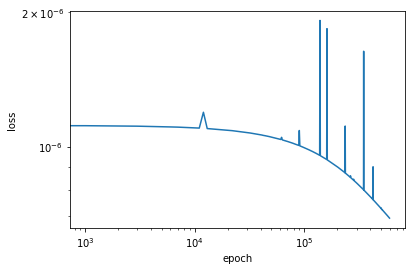

In [10]:
plt.loglog(df.loc[:,0],df.loc[:,1])
plt.ylabel('loss')
plt.xlabel('epoch')

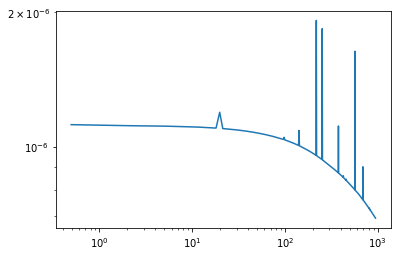

In [11]:
plt.loglog(df.loc[:,2],df.loc[:,1])